In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import sys
sys.path.append('/home/chenzhao/useful/scripts/python/pyFFTps')
import pyFFTps

fname = './halo-BoxSize-1000-redshift-0.txt'
### Now only support the single-precision float calculation
pos = np.loadtxt(fname).astype(np.float32)

print("Loaded {:d} haloes.".format(pos.shape[0]))
Nmesh = 256
MAS = 'CIC'
BoxSize = 1000 #Mpc/h
numden  = pos.shape[0] / BoxSize**3
print("Number density: {:.2e}".format(numden), "h^3/Mpc^3")

Loaded 46225 haloes.
Number density: 4.62e-05 h^3/Mpc^3


In [3]:
%%time
### No interlacing
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk0 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=False, numeff=numden, SNFlag=False,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Time taken = 0.053 seconds

Check delta: -1.0 -3.812602e-09 553.78345

Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 1.06 seconds
CPU times: user 1.17 s, sys: 197 ms, total: 1.37 s
Wall time: 1.21 s


In [4]:
%%time
### interlacing
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
print( delta.min(), delta.max())
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk1 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
0.0026245117 999.99524
Time taken = 1.810 seconds

-0.13856013 1.1155577
Check delta: -51.289955 -7.377821e-09 403.8881

Computing power spectrum of the field...
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 1.06
Time taken = 1.31 seconds
CPU times: user 2.85 s, sys: 1.01 s, total: 3.86 s
Wall time: 3.22 s


In [5]:
%%time
### 2 times Nmesh
Nmesh = 512
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.mean())
pko = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
0.0048828125 999.99817
Time taken = 15.281 seconds

Check delta: 2.1802407e-08

Computing power spectrum of the field...
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 8.14
Time taken = 10.18 seconds
CPU times: user 24.8 s, sys: 7.49 s, total: 32.3 s
Wall time: 26 s


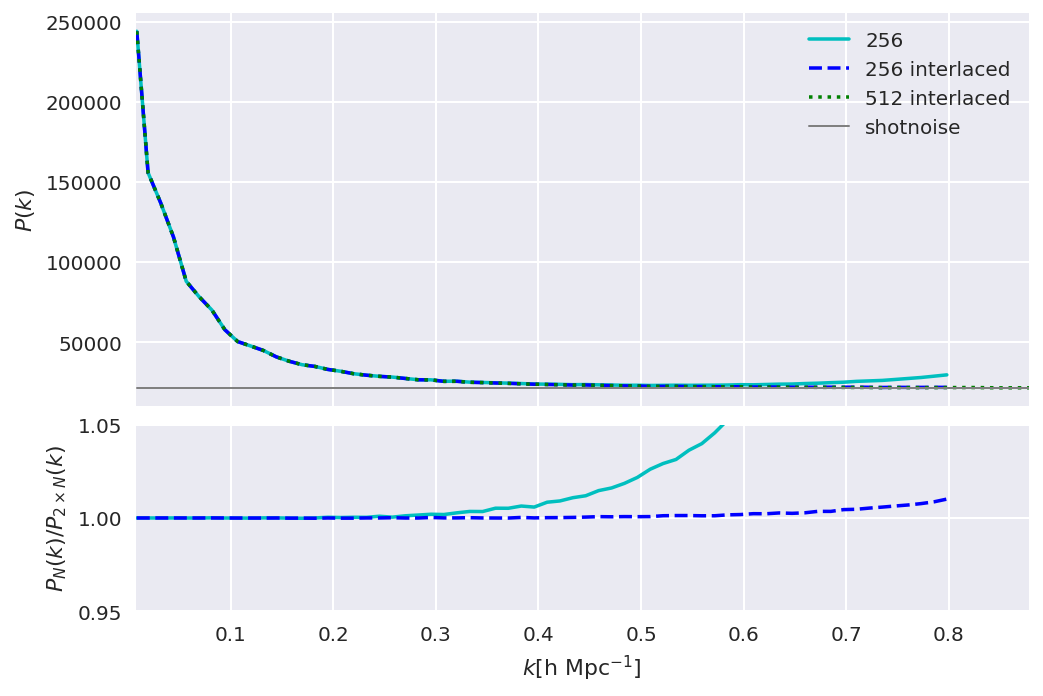

In [6]:
with plt.style.context('seaborn'):
    kind = pko[0] <= pk0[0].max()
    xlim = [0.9*pk0[0].min(), 1.1*pk0[0].max()]
    grid = plt.GridSpec(3,1,hspace=0.1)
    ax0 = plt.subplot(grid[:2,0])
    plt.plot(pk0[0], pk0[1], 'c-',  label='256')
    plt.plot(pk1[0], pk1[1], 'b--', label='256 interlaced')
    plt.plot(pko[0], pko[1], 'g:',  label='512 interlaced')
    plt.plot(pko[0], 1/numden*np.ones_like(pko[0]), 
             'gray', lw=1.0, label='shotnoise')
    plt.legend()
    # plt.xscale('log')
    # plt.yscale('log')
    ax0.set_xticklabels([])
    plt.xlim(xlim)
    # plt.ylim(0, 120)
    plt.ylabel(r'$P(k)$')
    plt.subplot(grid[2,0])
    plt.plot(pk0[0], pk0[1]/pko[1][kind], 'c-')
    plt.plot(pk0[0], pk1[1]/pko[1][kind], 'b--')
    # plt.xscale('log')
    plt.xlabel(r'$k [{\rm h\ Mpc^{-1}}]$')
    plt.xlim(xlim)
    plt.ylim([0.95,1.05])
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')